# 🚀 Step-by-Step Tutorial: API → SQLite → Pandas

This notebook demonstrates the complete ETL pipeline:
1. **Extract** data from SpaceX API
2. **Transform** and load into SQLite database
3. **Analyze** using Pandas

Let's break it down step by step!


## 📦 Step 1: Import Required Libraries

First, we need to import the libraries we'll use:
- `requests` - for making HTTP API calls
- `sqlite3` - for database operations
- `pandas` - for data analysis
- `json` - for handling JSON data


In [8]:
import requests
import sqlite3
import pandas as pd
import json
from pathlib import Path
from typing import Dict, List, Set, Any

# Base URL for SpaceX API
BASE_URL = "https://api.spacexdata.com/v4"
print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 🌐 Step 2: Fetch Data from API

### 2.1: Understanding API Calls

An API (Application Programming Interface) is a way to get data from a server. We use HTTP GET requests to fetch data.

**Key concepts:**
- **URL**: The address where the data lives
- **GET request**: Asking the server for data
- **JSON response**: Data comes back in JSON format (like a Python dictionary)


In [9]:
# Step 2.1: Make a simple API call to get all launches
print("📡 Fetching launches from SpaceX API...")

# Make GET request to the API
response = requests.get(f"{BASE_URL}/launches", timeout=20)

# Check if request was successful (status code 200)
print(f"Status Code: {response.status_code}")

# Raise an error if request failed
response.raise_for_status()

# Convert JSON response to Python dictionary/list
launches = response.json()

print(f"✅ Successfully fetched {len(launches)} launches!")
print(f"\nFirst launch example:")
print(json.dumps(launches[0], indent=2))


📡 Fetching launches from SpaceX API...
Status Code: 200
✅ Successfully fetched 205 launches!

First launch example:
{
  "fairings": {
    "reused": false,
    "recovery_attempt": false,
    "recovered": false,
    "ships": []
  },
  "links": {
    "patch": {
      "small": "https://images2.imgbox.com/94/f2/NN6Ph45r_o.png",
      "large": "https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"
    },
    "reddit": {
      "campaign": null,
      "launch": null,
      "media": null,
      "recovery": null
    },
    "flickr": {
      "small": [],
      "original": []
    },
    "presskit": null,
    "webcast": "https://www.youtube.com/watch?v=0a_00nJ_Y88",
    "youtube_id": "0a_00nJ_Y88",
    "article": "https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html",
    "wikipedia": "https://en.wikipedia.org/wiki/DemoSat"
  },
  "static_fire_date_utc": "2006-03-17T00:00:00.000Z",
  "static_fire_date_unix": 1142553600,
  "net": false,
  "window": 0,
  "rocket": "5e9d0d95eda69955

### 2.2: Understanding the Data Structure

Each launch contains:
- `id`: Unique SpaceX ID (string like "5e9d0d95eda69955f709d1eb")
- `rocket`: Reference to rocket ID (we need to fetch rocket details separately)
- `launchpad`: Reference to launchpad ID (we need to fetch launchpad details separately)
- `name`, `date_utc`, `success`, `details`: Direct data we can use

**Problem**: The API gives us rocket/launchpad as IDs, not full details. We need to:
1. Extract unique rocket IDs
2. Extract unique launchpad IDs
3. Fetch details for each unique ID (only once per ID!)


In [10]:
# Step 2.2: Extract unique rocket and launchpad IDs
print("🔍 Extracting unique IDs from launches...")

rocket_ids = set()  # Set automatically removes duplicates
launchpad_ids = set()

for launch in launches:
    rocket_id = launch.get("rocket")
    launchpad_id = launch.get("launchpad")
    
    if rocket_id:
        rocket_ids.add(rocket_id)
    if launchpad_id:
        launchpad_ids.add(launchpad_id)

print(f"✅ Found {len(rocket_ids)} unique rockets")
print(f"✅ Found {len(launchpad_ids)} unique launchpads")
print(f"\nExample rocket IDs: {list(rocket_ids)[:3]}")
print(f"Example launchpad IDs: {list(launchpad_ids)[:3]}")


🔍 Extracting unique IDs from launches...
✅ Found 3 unique rockets
✅ Found 4 unique launchpads

Example rocket IDs: ['5e9d0d95eda69974db09d1ed', '5e9d0d95eda69955f709d1eb', '5e9d0d95eda69973a809d1ec']
Example launchpad IDs: ['5e9e4502f509092b78566f87', '5e9e4502f5090995de566f86', '5e9e4501f509094ba4566f84']


### 2.3: Fetch Rocket Details

Now we fetch details for each unique rocket. **Important**: We only fetch each rocket once, even if it's used in 100 launches!


In [11]:
# Step 2.3: Fetch rocket details
print("🚀 Fetching rocket details...")

rockets_map = {}  # Dictionary: {rocket_id: rocket_data}

for rocket_id in rocket_ids:
    # Make API call for this specific rocket
    response = requests.get(f"{BASE_URL}/rockets/{rocket_id}", timeout=20)
    response.raise_for_status()
    rocket_data = response.json()
    
    # Store in dictionary for easy lookup
    rockets_map[rocket_id] = rocket_data
    
    print(f"  ✓ Fetched: {rocket_data.get('name', 'Unknown')}")

print(f"\n✅ Fetched {len(rockets_map)} rockets")
print(f"\nExample rocket data:")
print(json.dumps(list(rockets_map.values())[0], indent=2))


🚀 Fetching rocket details...
  ✓ Fetched: Falcon Heavy
  ✓ Fetched: Falcon 1
  ✓ Fetched: Falcon 9

✅ Fetched 3 rockets

Example rocket data:
{
  "height": {
    "meters": 70,
    "feet": 229.6
  },
  "diameter": {
    "meters": 12.2,
    "feet": 39.9
  },
  "mass": {
    "kg": 1420788,
    "lb": 3125735
  },
  "first_stage": {
    "thrust_sea_level": {
      "kN": 22819,
      "lbf": 5130000
    },
    "thrust_vacuum": {
      "kN": 24681,
      "lbf": 5548500
    },
    "reusable": true,
    "engines": 27,
    "fuel_amount_tons": 1155,
    "burn_time_sec": 162
  },
  "second_stage": {
    "thrust": {
      "kN": 934,
      "lbf": 210000
    },
    "payloads": {
      "composite_fairing": {
        "height": {
          "meters": 13.1,
          "feet": 43
        },
        "diameter": {
          "meters": 5.2,
          "feet": 17.1
        }
      },
      "option_1": "dragon"
    },
    "reusable": false,
    "engines": 1,
    "fuel_amount_tons": 90,
    "burn_time_sec": 397
  },

### 2.4: Fetch Launchpad Details

Same process for launchpads - fetch each unique launchpad only once.


In [12]:
# Step 2.4: Fetch launchpad details
print("🏁 Fetching launchpad details...")

launchpads_map = {}  # Dictionary: {launchpad_id: launchpad_data}

for launchpad_id in launchpad_ids:
    # Make API call for this specific launchpad
    response = requests.get(f"{BASE_URL}/launchpads/{launchpad_id}", timeout=20)
    response.raise_for_status()
    launchpad_data = response.json()
    
    # Store in dictionary for easy lookup
    launchpads_map[launchpad_id] = launchpad_data
    
    print(f"  ✓ Fetched: {launchpad_data.get('name', 'Unknown')}")

print(f"\n✅ Fetched {len(launchpads_map)} launchpads")
print(f"\nExample launchpad data:")
print(json.dumps(list(launchpads_map.values())[0], indent=2))


🏁 Fetching launchpad details...
  ✓ Fetched: VAFB SLC 4E
  ✓ Fetched: Kwajalein Atoll
  ✓ Fetched: CCSFS SLC 40
  ✓ Fetched: KSC LC 39A

✅ Fetched 4 launchpads

Example launchpad data:
{
  "images": {
    "large": [
      "https://i.imgur.com/asp5L08.png"
    ]
  },
  "name": "VAFB SLC 4E",
  "full_name": "Vandenberg Space Force Base Space Launch Complex 4E",
  "locality": "Vandenberg Space Force Base",
  "region": "California",
  "latitude": 34.632093,
  "longitude": -120.610829,
  "launch_attempts": 28,
  "launch_successes": 27,
  "rockets": [
    "5e9d0d95eda69973a809d1ec"
  ],
  "timezone": "America/Los_Angeles",
  "launches": [
    "5eb87ce1ffd86e000604b334",
    "5eb87cf0ffd86e000604b343",
    "5eb87cfdffd86e000604b34c",
    "5eb87d05ffd86e000604b354",
    "5eb87d08ffd86e000604b357",
    "5eb87d0affd86e000604b359",
    "5eb87d0fffd86e000604b35d",
    "5eb87d14ffd86e000604b361",
    "5eb87d16ffd86e000604b363",
    "5eb87d1affd86e000604b367",
    "5eb87d1fffd86e000604b36b",
    "5e

## 💾 Step 3: Store Data in SQLite Database

### 3.1: Understanding SQLite

SQLite is a lightweight database that stores data in a single file. We'll create:
- **Tables**: Structured containers for data (like Excel sheets)
- **Rows**: Individual records
- **Columns**: Fields/attributes

**Why normalize?**
- Avoid storing duplicate data (e.g., "Falcon 9" name 200 times)
- Store rocket once, reference by ID
- Easier to update (change rocket name in one place)


In [13]:
# Step 3.1: Create database connection
DB_PATH = Path("../Data/DB/tutorial.db")
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

# Connect to SQLite (creates file if it doesn't exist)
conn = sqlite3.connect(DB_PATH)
print(f"✅ Connected to database: {DB_PATH}")

# Get cursor (used to execute SQL commands)
cur = conn.cursor()
print("✅ Cursor created")


✅ Connected to database: ../Data/DB/tutorial.db
✅ Cursor created


### 3.2: Create Tables (Schema)

We create three tables:
1. **rockets** - Dimension table (stores rocket info once)
2. **launchpads** - Dimension table (stores launchpad info once)
3. **launches** - Fact table (stores each launch, references rockets/launchpads by ID)

**Key concepts:**
- `PRIMARY KEY`: Unique identifier for each row
- `AUTOINCREMENT`: Automatically generates 1, 2, 3, ...
- `FOREIGN KEY`: Links to another table
- `UNIQUE`: Prevents duplicates


In [14]:
# Step 3.2: Create rockets table
cur.execute("""
    CREATE TABLE IF NOT EXISTS rockets (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        spacex_id TEXT UNIQUE,
        name TEXT,
        type TEXT,
        active INTEGER
    )
""")
print("✅ Created 'rockets' table")

# Create launchpads table
cur.execute("""
    CREATE TABLE IF NOT EXISTS launchpads (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        spacex_id TEXT UNIQUE,
        name TEXT,
        region TEXT,
        latitude REAL,
        longitude REAL
    )
""")
print("✅ Created 'launchpads' table")

# Create launches table (with foreign keys)
cur.execute("""
    CREATE TABLE IF NOT EXISTS launches (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        spacex_id TEXT UNIQUE,
        name TEXT,
        date_utc TEXT,
        success INTEGER,
        rocket_id INTEGER,
        launchpad_id INTEGER,
        details TEXT,
        FOREIGN KEY (rocket_id) REFERENCES rockets(id),
        FOREIGN KEY (launchpad_id) REFERENCES launchpads(id)
    )
""")
print("✅ Created 'launches' table")

# Save changes to database
conn.commit()
print("✅ Schema created and committed!")


✅ Created 'rockets' table
✅ Created 'launchpads' table
✅ Created 'launches' table
✅ Schema created and committed!


### 3.3: Insert Rockets into Database

**Important concepts:**
- **Parameterized queries**: Use `?` placeholders to prevent SQL injection
- **INSERT OR IGNORE**: If rocket already exists, skip it (idempotent)
- **Tuple of values**: Pass data as `(value1, value2, ...)`


In [15]:
# Step 3.3: Insert rockets
print("💾 Inserting rockets into database...")

for spacex_id, rocket_data in rockets_map.items():
    # Use parameterized query (SAFE - prevents SQL injection)
    cur.execute("""
        INSERT OR IGNORE INTO rockets (spacex_id, name, type, active)
        VALUES (?, ?, ?, ?)
    """, (
        spacex_id,                    # spacex_id
        rocket_data.get("name"),      # name
        rocket_data.get("type"),      # type
        1 if rocket_data.get("active") else 0  # active (convert bool to int)
    ))

# Commit all inserts at once (faster than committing after each)
conn.commit()
print(f"✅ Inserted {len(rockets_map)} rockets")

# Verify: Count rows in table
cur.execute("SELECT COUNT(*) FROM rockets")
count = cur.fetchone()[0]
print(f"✅ Database now contains {count} rockets")


💾 Inserting rockets into database...
✅ Inserted 3 rockets
✅ Database now contains 3 rockets


### 3.4: Insert Launchpads into Database

Same process for launchpads.


In [16]:
# Step 3.4: Insert launchpads
print("💾 Inserting launchpads into database...")

for spacex_id, launchpad_data in launchpads_map.items():
    cur.execute("""
        INSERT OR IGNORE INTO launchpads (spacex_id, name, region, latitude, longitude)
        VALUES (?, ?, ?, ?, ?)
    """, (
        spacex_id,
        launchpad_data.get("name"),
        launchpad_data.get("region"),
        launchpad_data.get("latitude"),
        launchpad_data.get("longitude")
    ))

conn.commit()
print(f"✅ Inserted {len(launchpads_map)} launchpads")

# Verify
cur.execute("SELECT COUNT(*) FROM launchpads")
count = cur.fetchone()[0]
print(f"✅ Database now contains {count} launchpads")


💾 Inserting launchpads into database...
✅ Inserted 4 launchpads
✅ Database now contains 4 launchpads


### 3.5: Build ID Mapping (CRITICAL STEP!)

**The Challenge:**
- API gives us: `"rocket": "5e9d0d95eda69955f709d1eb"` (string ID)
- Database needs: `rocket_id: 1` (integer ID)

**The Solution:**
1. Query database to get all rockets with their internal IDs
2. Build a dictionary: `{spacex_id: internal_id}`
3. Use this dictionary to convert when inserting launches


In [17]:
# Step 3.5: Build ID mapping dictionaries
print("🔗 Building ID mappings...")

# Query: Get all rockets with their internal IDs
cur.execute("SELECT id, spacex_id FROM rockets")
rocket_rows = cur.fetchall()

# Build dictionary: {spacex_id: internal_id}
rocket_id_map = {spacex_id: internal_id for internal_id, spacex_id in rocket_rows}

print(f"✅ Rocket ID mapping: {len(rocket_id_map)} entries")
print(f"Example mapping: {dict(list(rocket_id_map.items())[:2])}")

# Same for launchpads
cur.execute("SELECT id, spacex_id FROM launchpads")
launchpad_rows = cur.fetchall()
launchpad_id_map = {spacex_id: internal_id for internal_id, spacex_id in launchpad_rows}

print(f"✅ Launchpad ID mapping: {len(launchpad_id_map)} entries")
print(f"Example mapping: {dict(list(launchpad_id_map.items())[:2])}")


🔗 Building ID mappings...
✅ Rocket ID mapping: 3 entries
Example mapping: {'5e9d0d95eda69955f709d1eb': 2, '5e9d0d95eda69973a809d1ec': 3}
✅ Launchpad ID mapping: 4 entries
Example mapping: {'5e9e4501f509094ba4566f84': 3, '5e9e4502f509092b78566f87': 1}


### 3.6: Insert Launches (Using Foreign Keys)

Now we insert launches, but we must:
1. Convert SpaceX rocket ID → internal rocket ID
2. Convert SpaceX launchpad ID → internal launchpad ID
3. Handle NULL values for `success` field


In [18]:
# Step 3.6: Insert launches
print("💾 Inserting launches into database...")

inserted_count = 0

for launch in launches:
    # Get SpaceX IDs from API data
    rocket_spacex_id = launch.get("rocket")
    launchpad_spacex_id = launch.get("launchpad")
    
    # Convert to internal IDs using our mapping dictionaries
    rocket_id = rocket_id_map.get(rocket_spacex_id)
    launchpad_id = launchpad_id_map.get(launchpad_spacex_id)
    
    # Handle success field (can be None, True, or False)
    success_val = launch.get("success")
    if success_val is None:
        success_int = None
    else:
        success_int = 1 if success_val else 0
    
    # Insert launch with internal IDs (foreign keys)
    cur.execute("""
        INSERT OR IGNORE INTO launches
        (spacex_id, name, date_utc, success, rocket_id, launchpad_id, details)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (
        launch.get("id"),        # spacex_id
        launch.get("name"),       # name
        launch.get("date_utc"),   # date_utc
        success_int,              # success (converted to 0/1/None)
        rocket_id,                # rocket_id (internal ID, not SpaceX ID!)
        launchpad_id,             # launchpad_id (internal ID, not SpaceX ID!)
        launch.get("details")     # details
    ))
    
    inserted_count += 1
    if inserted_count % 50 == 0:
        print(f"  ✓ Processed {inserted_count} launches...")

# Commit all launches at once
conn.commit()
print(f"✅ Inserted {inserted_count} launches")

# Verify
cur.execute("SELECT COUNT(*) FROM launches")
count = cur.fetchone()[0]
print(f"✅ Database now contains {count} launches")


💾 Inserting launches into database...
  ✓ Processed 50 launches...
  ✓ Processed 100 launches...
  ✓ Processed 150 launches...
  ✓ Processed 200 launches...
✅ Inserted 205 launches
✅ Database now contains 205 launches


### 3.7: Verify Database Contents

Let's check what we've stored in the database.


In [19]:
# Step 3.7: Verify database contents
print("📊 Database Summary:")
print("-" * 50)

# Count each table
for table_name in ["rockets", "launchpads", "launches"]:
    cur.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cur.fetchone()[0]
    print(f"{table_name.capitalize()}: {count} rows")

# Show sample data
print("\n📋 Sample Rocket:")
cur.execute("SELECT id, spacex_id, name, active FROM rockets LIMIT 3")
for row in cur.fetchall():
    print(f"  ID: {row[0]}, SpaceX ID: {row[1]}, Name: {row[2]}, Active: {row[3]}")

print("\n📋 Sample Launch:")
cur.execute("""
    SELECT l.name, l.date_utc, l.success, r.name as rocket_name
    FROM launches l
    JOIN rockets r ON l.rocket_id = r.id
    LIMIT 3
""")
for row in cur.fetchall():
    print(f"  {row[0]} ({row[1][:10]}) - Success: {row[2]}, Rocket: {row[3]}")


📊 Database Summary:
--------------------------------------------------
Rockets: 3 rows
Launchpads: 4 rows
Launches: 205 rows

📋 Sample Rocket:
  ID: 1, SpaceX ID: 5e9d0d95eda69974db09d1ed, Name: Falcon Heavy, Active: 1
  ID: 2, SpaceX ID: 5e9d0d95eda69955f709d1eb, Name: Falcon 1, Active: 0
  ID: 3, SpaceX ID: 5e9d0d95eda69973a809d1ec, Name: Falcon 9, Active: 1

📋 Sample Launch:
  FalconSat (2006-03-24) - Success: 0, Rocket: Falcon 1
  DemoSat (2007-03-21) - Success: 0, Rocket: Falcon 1
  Trailblazer (2008-08-03) - Success: 0, Rocket: Falcon 1


## 📊 Step 4: Read Data with Pandas

### 4.1: Understanding Pandas

Pandas is a powerful library for data analysis. It provides:
- **DataFrames**: Like Excel spreadsheets, but much more powerful
- **Easy filtering, grouping, merging**
- **Statistical analysis**
- **Visualization support**

**Key advantage**: Much easier than writing complex SQL queries!


In [20]:
# Step 4.1: Load tables into pandas DataFrames
print("📊 Loading data from SQLite into pandas...")

# Read entire tables as DataFrames
df_launches = pd.read_sql_query("SELECT * FROM launches", conn)
df_rockets = pd.read_sql_query("SELECT * FROM rockets", conn)
df_launchpads = pd.read_sql_query("SELECT * FROM launchpads", conn)

print(f"✅ Loaded {len(df_launches)} launches")
print(f"✅ Loaded {len(df_rockets)} rockets")
print(f"✅ Loaded {len(df_launchpads)} launchpads")

# Show basic info
print("\n📋 Launches DataFrame Info:")
print(df_launches.head())
print(f"\nColumns: {list(df_launches.columns)}")


📊 Loading data from SQLite into pandas...
✅ Loaded 205 launches
✅ Loaded 3 rockets
✅ Loaded 4 launchpads

📋 Launches DataFrame Info:
   id                 spacex_id         name                  date_utc  \
0   1  5eb87cd9ffd86e000604b32a    FalconSat  2006-03-24T22:30:00.000Z   
1   2  5eb87cdaffd86e000604b32b      DemoSat  2007-03-21T01:10:00.000Z   
2   3  5eb87cdbffd86e000604b32c  Trailblazer  2008-08-03T03:34:00.000Z   
3   4  5eb87cdbffd86e000604b32d       RatSat  2008-09-28T23:15:00.000Z   
4   5  5eb87cdcffd86e000604b32e     RazakSat  2009-07-13T03:35:00.000Z   

   success  rocket_id  launchpad_id  \
0      0.0          2             2   
1      0.0          2             2   
2      0.0          2             2   
3      1.0          2             2   
4      1.0          2             2   

                                             details  
0   Engine failure at 33 seconds and loss of vehicle  
1  Successful first stage burn and transition to ...  
2  Residual stage 1 th

### 4.2: Merge DataFrames (Join Tables)

We need to combine the three tables to get a complete picture. This is like SQL JOIN, but easier with pandas!

**Merge strategy:**
1. Start with `launches` (fact table)
2. Merge `rockets` on `rocket_id`
3. Merge `launchpads` on `launchpad_id`


In [21]:
# Step 4.2: Merge launches with rockets
print("🔗 Merging launches with rockets...")

# Left merge: Keep all launches, add rocket info
master = df_launches.merge(
    df_rockets,
    how="left",                    # Keep all launches (left table)
    left_on="rocket_id",           # Join key from launches
    right_on="id",                 # Join key from rockets
    suffixes=("_launch", "_rocket")  # Add suffix to duplicate column names
)

print(f"✅ Merged: {len(master)} rows")
print(f"Columns after merge: {list(master.columns)}")

# Show sample
print("\n📋 Sample merged data:")
print(master[["name_launch", "name_rocket", "date_utc", "success"]].head())


🔗 Merging launches with rockets...
✅ Merged: 205 rows
Columns after merge: ['id_launch', 'spacex_id_launch', 'name_launch', 'date_utc', 'success', 'rocket_id', 'launchpad_id', 'details', 'id_rocket', 'spacex_id_rocket', 'name_rocket', 'type', 'active']

📋 Sample merged data:
   name_launch name_rocket                  date_utc  success
0    FalconSat    Falcon 1  2006-03-24T22:30:00.000Z      0.0
1      DemoSat    Falcon 1  2007-03-21T01:10:00.000Z      0.0
2  Trailblazer    Falcon 1  2008-08-03T03:34:00.000Z      0.0
3       RatSat    Falcon 1  2008-09-28T23:15:00.000Z      1.0
4     RazakSat    Falcon 1  2009-07-13T03:35:00.000Z      1.0


In [22]:
# Step 4.2 (continued): Merge with launchpads
print("🔗 Merging with launchpads...")

master = master.merge(
    df_launchpads,
    how="left",                    # Keep all launches
    left_on="launchpad_id",        # Join key from master
    right_on="id",                 # Join key from launchpads
    suffixes=("", "_launchpad")    # Suffix for duplicates
)

print(f"✅ Final merged dataset: {len(master)} rows")
print(f"Total columns: {len(master.columns)}")

# Show complete sample
print("\n📋 Complete sample row:")
print(master[["name_launch", "name_rocket", "name", "region", "date_utc", "success"]].head(1))


🔗 Merging with launchpads...
✅ Final merged dataset: 205 rows
Total columns: 19

📋 Complete sample row:
  name_launch name_rocket             name            region  \
0   FalconSat    Falcon 1  Kwajalein Atoll  Marshall Islands   

                   date_utc  success  
0  2006-03-24T22:30:00.000Z      0.0  


## 🔍 Step 5: Analyze Data with Pandas

### 5.1: Basic Data Exploration

Let's explore the data and answer some questions!


In [23]:
# Step 5.1: Basic statistics
print("📊 Basic Statistics:")
print("=" * 50)

# Data types
print("\nData Types:")
print(master.dtypes)

# Missing values
print("\nMissing Values:")
print(master.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(master.describe())


📊 Basic Statistics:

Data Types:
id_launch             int64
spacex_id_launch     object
name_launch          object
date_utc             object
success             float64
rocket_id             int64
launchpad_id          int64
details              object
id_rocket             int64
spacex_id_rocket     object
name_rocket          object
type                 object
active                int64
id                    int64
spacex_id            object
name                 object
region               object
latitude            float64
longitude           float64
dtype: object

Missing Values:
id_launch            0
spacex_id_launch     0
name_launch          0
date_utc             0
success             19
rocket_id            0
launchpad_id         0
details             71
id_rocket            0
spacex_id_rocket     0
name_rocket          0
type                 0
active               0
id                   0
spacex_id            0
name                 0
region               0
latitude     

### 5.2: Question 1 - Which Rocket Has Flown the Most Missions?

**Pandas operations used:**
- `groupby()`: Group data by a column
- `count()`: Count occurrences
- `sort_values()`: Sort results


In [24]:
# Step 5.2: Count launches per rocket
print("🚀 Question 1: Which rocket has flown the most missions?")
print("=" * 50)

# Group by rocket name and count launches
workhorse = master.groupby("name_rocket")["spacex_id_launch"].count().sort_values(ascending=False)

print("\nLaunches per Rocket:")
print(workhorse)

print(f"\n✅ Answer: {workhorse.index[0]} with {workhorse.iloc[0]} launches")


🚀 Question 1: Which rocket has flown the most missions?

Launches per Rocket:
name_rocket
Falcon 9        195
Falcon 1          5
Falcon Heavy      5
Name: spacex_id_launch, dtype: int64

✅ Answer: Falcon 9 with 195 launches


### 5.3: Question 2 - Which Rocket Has the Highest Success Rate?

**Pandas operations used:**
- `dropna()`: Remove rows with missing values
- `agg()`: Aggregate multiple statistics
- Filtering with conditions


In [25]:
# Step 5.3: Calculate success rates
print("📈 Question 2: Which rocket has the highest success rate?")
print("=" * 50)

# Remove launches with unknown success status
launches_with_success = master.dropna(subset=["success"])

# Group by rocket and calculate statistics
reliability = launches_with_success.groupby("name_rocket").agg(
    launches=("spacex_id_launch", "count"),      # Count total launches
    success_rate=("success", "mean")            # Mean of success (0 or 1) = success rate
)

# Filter: Only rockets with 5+ launches (avoid skew from small samples)
reliability_filtered = reliability[reliability["launches"] >= 5].sort_values(
    by="success_rate", 
    ascending=False
)

print("\nSuccess Rates (rockets with 5+ launches):")
print(reliability_filtered)

print(f"\n✅ Answer: {reliability_filtered.index[0]} with {reliability_filtered.iloc[0]['success_rate']:.2%} success rate")


📈 Question 2: Which rocket has the highest success rate?

Success Rates (rockets with 5+ launches):
             launches  success_rate
name_rocket                        
Falcon 9          178      0.988764
Falcon 1            5      0.400000

✅ Answer: Falcon 9 with 98.88% success rate


### 5.4: Question 3 - Launch Cadence (Launches per Year)

**Pandas operations used:**
- `pd.to_datetime()`: Convert string to datetime
- `.dt.year`: Extract year from datetime
- `groupby()` with datetime


📅 Question 3: How many launches per year?

Launches per Year:
year
2006     1
2007     1
2008     2
2009     1
2010     2
2012     2
2013     3
2014     6
2015     7
2016     9
2017    18
2018    21
2019    13
2020    26
2021    31
2022    62
Name: spacex_id_launch, dtype: int64

📈 Trend Analysis:
  First year: 2006 - 1 launches
  Last year: 2022 - 62 launches
  Growth: 6100% increase


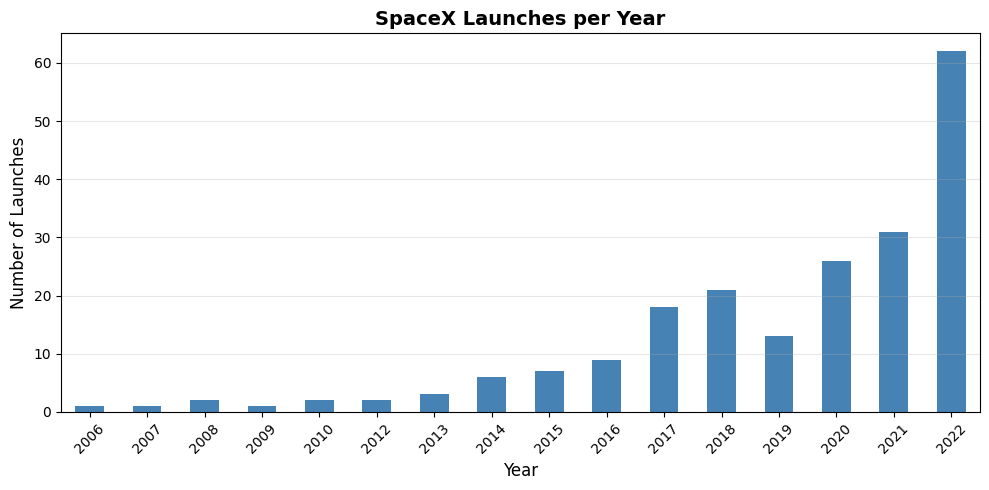


✅ Answer: Launch cadence is increasing over time!


In [26]:
# Step 5.4: Analyze launch cadence
print("📅 Question 3: How many launches per year?")
print("=" * 50)

# Convert date_utc to datetime
master["date_utc"] = pd.to_datetime(master["date_utc"], errors="coerce")

# Extract year
master["year"] = master["date_utc"].dt.year

# Count launches per year
launches_per_year = master.groupby("year")["spacex_id_launch"].count().sort_index()

print("\nLaunches per Year:")
print(launches_per_year)

# Check trend
print(f"\n📈 Trend Analysis:")
print(f"  First year: {launches_per_year.index[0]} - {launches_per_year.iloc[0]} launches")
print(f"  Last year: {launches_per_year.index[-1]} - {launches_per_year.iloc[-1]} launches")
print(f"  Growth: {((launches_per_year.iloc[-1] / launches_per_year.iloc[0]) - 1) * 100:.0f}% increase")

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
launches_per_year.plot(kind="bar", color="steelblue")
plt.title("SpaceX Launches per Year", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Launches", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Answer: Launch cadence is increasing over time!")


### 5.5: Question 4 - Which Region Has Hosted the Most Launches?

Simple groupby and count operation.


🌍 Question 4: Which region has hosted the most launches?

Launches by Region:
region
Florida             170
California           30
Marshall Islands      5
Name: spacex_id_launch, dtype: int64

✅ Answer: Florida with 170 launches


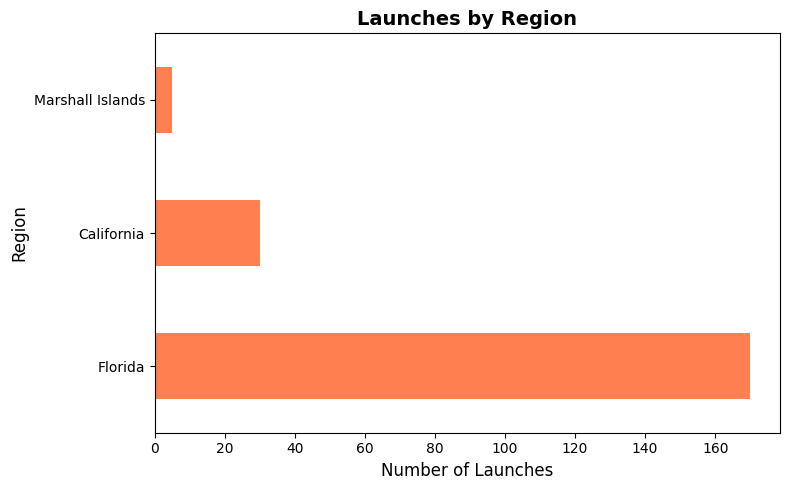

In [27]:
# Step 5.5: Analyze by region
print("🌍 Question 4: Which region has hosted the most launches?")
print("=" * 50)

by_region = master.groupby("region")["spacex_id_launch"].count().sort_values(ascending=False)

print("\nLaunches by Region:")
print(by_region)

print(f"\n✅ Answer: {by_region.index[0]} with {by_region.iloc[0]} launches")

# Visualize
plt.figure(figsize=(8, 5))
by_region.plot(kind="barh", color="coral")
plt.title("Launches by Region", fontsize=14, fontweight="bold")
plt.xlabel("Number of Launches", fontsize=12)
plt.ylabel("Region", fontsize=12)
plt.tight_layout()
plt.show()


### 5.6: Question 5 - Failure Analysis

**Pandas operations used:**
- Boolean filtering: `df[df["column"] == value]`
- Selecting specific columns
- Sorting


In [28]:
# Step 5.6: Analyze failures
print("❌ Question 5: What are the failed missions?")
print("=" * 50)

# Filter for failed launches (success == 0)
failed = master[master["success"] == 0][
    ["name_launch", "date_utc", "details", "name_rocket", "region"]
].sort_values("date_utc")

print(f"\nTotal Failed Missions: {len(failed)}")
print("\nFailed Missions Details:")
print(failed.to_string(index=False))

# Patterns
print("\n📊 Failure Patterns:")
print(f"  By Rocket:")
print(failed["name_rocket"].value_counts())
print(f"\n  By Region:")
print(failed["region"].value_counts())

print("\n✅ Answer: See table above for all failed missions")


❌ Question 5: What are the failed missions?

Total Failed Missions: 5

Failed Missions Details:
name_launch                  date_utc                                                                                                                                                                                                                                                                                                             details name_rocket           region
  FalconSat 2006-03-24 22:30:00+00:00                                                                                                                                                                                                                                                                    Engine failure at 33 seconds and loss of vehicle    Falcon 1 Marshall Islands
    DemoSat 2007-03-21 01:10:00+00:00                                                                                                                     

## 💾 Step 6: Save Results

Save the merged dataset and analysis results to CSV files.


In [29]:
# Step 6: Save results
PROCESSED_DIR = Path("../Data/Procesed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Save master dataset
master.to_csv(PROCESSED_DIR / "tutorial_mission_report.csv", index=False)
print(f"✅ Saved master dataset: {PROCESSED_DIR / 'tutorial_mission_report.csv'}")

# Save failed missions
failed.to_csv(PROCESSED_DIR / "tutorial_failed_missions.csv", index=False)
print(f"✅ Saved failed missions: {PROCESSED_DIR / 'tutorial_failed_missions.csv'}")

# Close database connection
conn.close()
print("✅ Database connection closed")

print("\n🎉 Tutorial Complete!")
print("=" * 50)
print("You've learned:")
print("  1. ✅ How to fetch data from APIs using requests")
print("  2. ✅ How to store data in SQLite database")
print("  3. ✅ How to read and analyze data with pandas")
print("  4. ✅ How to merge DataFrames and perform analysis")


✅ Saved master dataset: ../Data/Procesed/tutorial_mission_report.csv
✅ Saved failed missions: ../Data/Procesed/tutorial_failed_missions.csv
✅ Database connection closed

🎉 Tutorial Complete!
You've learned:
  1. ✅ How to fetch data from APIs using requests
  2. ✅ How to store data in SQLite database
  3. ✅ How to read and analyze data with pandas
  4. ✅ How to merge DataFrames and perform analysis


## 📚 Summary: Key Concepts Learned

### API (requests library)
- **GET requests**: `requests.get(url)` to fetch data
- **JSON parsing**: `response.json()` converts JSON to Python dict/list
- **Error handling**: `response.raise_for_status()` checks for HTTP errors
- **Efficiency**: Fetch unique IDs only once, not for every launch

### SQLite Database
- **Connection**: `sqlite3.connect(path)` creates/connects to database
- **Cursor**: `conn.cursor()` executes SQL commands
- **CREATE TABLE**: Define schema with columns, types, constraints
- **INSERT**: Use parameterized queries (`?` placeholders) for safety
- **Foreign Keys**: Link tables together (launches → rockets, launches → launchpads)
- **ID Mapping**: Convert string IDs (from API) to integer IDs (in database)

### Pandas
- **DataFrames**: Load SQL data with `pd.read_sql_query()`
- **Merge**: Combine DataFrames with `df.merge()` (like SQL JOIN)
- **Groupby**: `df.groupby()` for aggregations
- **Filtering**: `df[df["column"] == value]` for boolean filtering
- **Aggregations**: `count()`, `mean()`, `sum()`, etc.

### Best Practices
1. ✅ Always use parameterized queries (prevent SQL injection)
2. ✅ Commit transactions after logical groups of operations
3. ✅ Use `INSERT OR IGNORE` for idempotent operations
4. ✅ Build ID mapping dictionaries for foreign key relationships
5. ✅ Handle NULL values explicitly
6. ✅ Close database connections when done
